   # Validação de Dados Modelados com Observados

Carregar arquivos para comparar dados monitorados com séries modelada (arquivos combine)

In [1]:
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import utm
import seaborn as sns
import datetime as dt
from bisect import bisect_left
import math
%matplotlib inline

def takeClosest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.
    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
       return after
    else:
       return before


## *Entradas*
* Selecionar arquivos de origem para preparar figuras.
* Inicializar variáveis para figuras.

### Parametrização dos arquivos de entrada

Ajustar diretório que contem o arquivo da estação e nomes de rodadas.

In [2]:
directory = str('E:/Mestrado/1.Resultados/QualidadedoAr/')
wrfdir = str('E:/Mestrado/1.Resultados/Meteorologia/')
mes   = ['jan','jul']
grade = 'd04_1km'
data  = ['20150109','20150724']
datawrf  = ['01-09','07-24']
periodo = ['Verão', 'Inverno']

moded = ['-','-20I','-20T','-20I-20T']
modnames = ['ED', 'ED-20I','ED-20T','ED-20I-20T']
modpt = ['_PT_ED-100I','_PT-20_ED-100I', '_PT_ED-100I-20T', '_PT-20_ED-100I-20T']
modptnames = ['PT_ED-100I', 'PT-20_ED-100I','PT_ED-100I-20T','PT-20_ED-100I-20T']
shapes = ['pirashape','RMSP']

spinup = 48
run_len = 24*7
gmt = 3

date_index = 0

In [3]:
#DADOS ESTACAO
estacao     = 'PIRACICABA (A)'
estlat,estlon = utm.to_latlon(easting=227797, northing=7487124, zone_letter='k', zone_number=23)
est = pd.read_csv(directory+'piracicaba.csv', delimiter=';')
#est['Hora'] = est['Hora'].apply(lambda x: '24:00' if x == '24:00:00' else x)
est['Hora'] = est['Hora'].apply(lambda x: dt.timedelta(hours=float(x[:2])))
est['Data'] = est['Data'].apply(lambda x: dt.datetime.strptime(x,'%d/%m/%Y'))
est['Data'] += est['Hora']
est.drop(columns=['Unnamed: 0','Hora','wind_dir','wind_dir_avg','temp','ur','wind_vel'], inplace=True)
est.set_index('Data', inplace=True)

## Abrir arquivos COMBINE ACONC e DEP

In [4]:
aconc = []
for m in moded:
    aconc.append(xr.open_dataset(directory+mes[date_index]+'.'+grade+m+'/COMBINE_ACONC_v521_intel_pira_riz_nudge_'+
                        mes[date_index]+'_'+data[date_index]+'.nc'))
for m in modpt:
    aconc.append(xr.open_dataset(directory+mes[date_index]+'.'+grade+m+'/COMBINE_ACONC_v521_intel_pira_riz_nudge_'+
                        mes[date_index]+'_'+data[date_index]+'.nc'))

for i in range(0,len(aconc)):
    aconc[i] = aconc[i].isel(LAY=0)

## Abrir arquivo WRF para buscar valores de LAT / LON

In [5]:
nc_wrf = Dataset(wrfdir+'arqWRF/'+mes[0]+'/wrf_fnl_pira_pedruzzi2016_nudge_'+
                 mes[0]+'/wrfout_'+grade[:3]+'_2015-'+datawrf[0]+'_00%3A00%3A00')

## Preparar coordenadas para XArray
* DATAS
* ALTITUDE
* LATITUDE
* LONGITUDE

In [6]:
# DATAS
dates = []
dates = [dt.datetime.strptime(str(aconc[0].attrs['SDATE']),'%Y%j')]
for i in range(1,aconc[0].dims['TSTEP']):
    dates.append(dates[0]+dt.timedelta(hours=i))
    
# LATITUDE
# LONGITUDE
croplat = int((nc_wrf.dimensions['south_north'].size-aconc[0].dims['ROW'])/2)
croplon = int((nc_wrf.dimensions['south_north'].size-aconc[0].dims['ROW'])/2)
lats      = nc_wrf.variables['XLAT'][0,croplat:-croplat,croplat:-croplat]
longs     = nc_wrf.variables['XLONG'][0,croplon:-croplon,croplon:-croplon]

# COORDENADAS PARA POSICIONAR ESTACAO
if (estlat > np.amin(lats) and
    estlat < np.amax(lats) and
    estlon > np.amin(longs)and
    estlon < np.amax(longs)):                
    esty     = lats[:,0].tolist().index(takeClosest(lats[:,0],estlat))     #index Lat da estação no domínio
    estx     = longs[0,:].tolist().index(takeClosest(longs[0,:],estlon))   #index Lat da estação no domínio

# PLOT CORNERS
llcrnrlon = np.min(longs)      #longitude of lower left hand corner of the selected map domain.
llcrnrlat = np.min(lats)       #latitude of upper right hand corner of the desired map domain (degrees).
urcrnrlon = np.max(longs)      #longitude of upper right hand corner of the selected map domain.
urcrnrlat = np.max(lats)      #latitude of upper right hand corner of the selected map domain.

coordlat  = np.linspace(llcrnrlat,urcrnrlat,num=aconc[0].dims['ROW'])
coordlon  = np.linspace(llcrnrlon,urcrnrlon,num=aconc[0].dims['COL'])

# ADJUSTMENTS
for a in aconc:
    a.coords['TSTEP'] = dates
    a.coords['ROW'] = coordlat
    a.coords['COL'] = coordlon
    a.rename({'ROW': 'LAT', 'COL': 'LON'}, inplace=True)
    for var in a.variables:
        if 'units' in a.variables[var].attrs:
            if a.variables[var].attrs['units'].split() != []:
                a.variables[var].attrs['units'] = a.variables[var].attrs['units'].split()[0]

for i in range(0,len(aconc)):
    aconc[i] = aconc[i].isel(TSTEP=slice(spinup,spinup+run_len))
    aconc[i].coords['TSTEP'] -= pd.Timedelta(gmt,'h')
weekd=[]
for d in aconc[0].TSTEP.dt.weekday:
    if d < 5:
        weekd.append('Weekday')
    else:
        weekd.append('Weekend')

D:\Users\50033096\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:36: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.


## Figuras - Séries Históricas

### Material Particulado

D:\Users\50033096\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


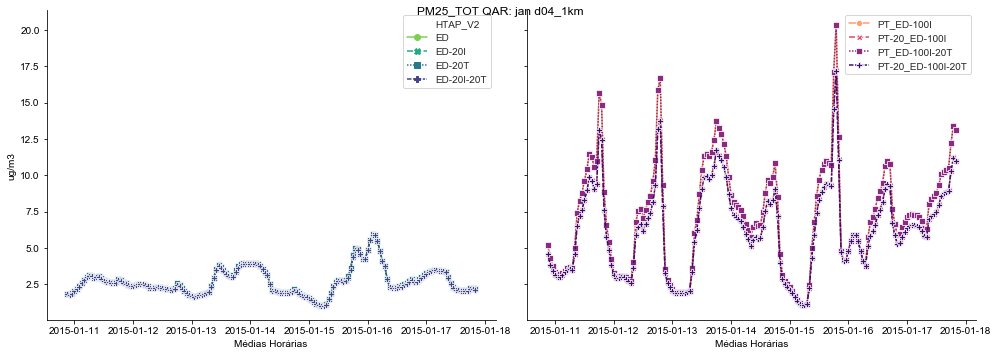

In [7]:
param = 'PM25_TOT'
mesplt = mes[date_index]
gradeplt = grade

ed={'TSTEP': aconc[0].TSTEP}
for i in range(0,len(moded)):
    ed[modnames[i]] = aconc[i].variables[param][:,:,:].mean(dim=['LAT', 'LON'])
ed_df = pd.DataFrame(ed)
ed_df.set_index('TSTEP', inplace=True)
ed_df=ed_df.stack()
ed_df = pd.DataFrame(ed_df.reset_index())
ed_df.columns = ['dt','HTAP_V2','qar']

pt={'TSTEP': aconc[0].TSTEP}
for i in range(len(moded),len(moded)+len(modpt)):
    pt[modptnames[i-4]] = aconc[i].variables[param][:,:,:].mean(dim=['LAT', 'LON'])
pt_df = pd.DataFrame(pt)
pt_df.set_index('TSTEP', inplace=True)
pt_df=pt_df.stack()
pt_df = pd.DataFrame(pt_df.reset_index())
pt_df.columns = ['dt','Local+HTAP','qar']

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(14,5), sharey=True) 
fig.suptitle(param+' QAR: '+mesplt+' '+gradeplt, fontsize=12)
sns.despine()
sns.set_style("whitegrid")
sns.lineplot(x=ed_df['dt'], y=ed_df['qar'], hue=ed_df['HTAP_V2'],
             palette='viridis_r',
             markers=True,
             style=ed_df['HTAP_V2'],
             ci=None,
             ax=axes[0])
sns.lineplot(x=pt_df['dt'], y=pt_df['qar'], hue=pt_df['Local+HTAP'], 
             palette='magma_r',
             markers=True,
             style=pt_df['Local+HTAP'],
             ci=None,
             ax=axes[1])
axes[0].set_xlabel('Médias Horárias')
axes[1].set_xlabel('Médias Horárias')
axes[0].legend()
axes[1].legend(labels=pt_df['Local+HTAP'].unique())
axes[0].set_ylabel(aconc[i].variables[param].attrs['units'])
fig.tight_layout()


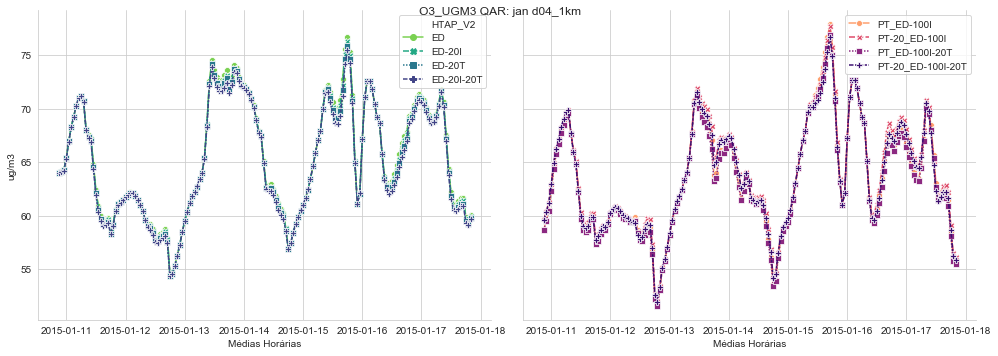

In [8]:
param = 'O3_UGM3'
mesplt = mes[date_index]
gradeplt = grade

ed={'TSTEP': aconc[0].TSTEP}
for i in range(0,len(moded)):
    ed[modnames[i]] = aconc[i].variables[param][:,:,:].mean(dim=['LAT', 'LON'])
ed_df = pd.DataFrame(ed)
ed_df.set_index('TSTEP', inplace=True)
ed_df=ed_df.stack()
ed_df = pd.DataFrame(ed_df.reset_index())
ed_df.columns = ['dt','HTAP_V2','qar']

pt={'TSTEP': aconc[0].TSTEP}
for i in range(len(moded),len(moded)+len(modpt)):
    pt[modptnames[i-4]] = aconc[i].variables[param][:,:,:].mean(dim=['LAT', 'LON'])
pt_df = pd.DataFrame(pt)
pt_df.set_index('TSTEP', inplace=True)
pt_df=pt_df.stack()
pt_df = pd.DataFrame(pt_df.reset_index())
pt_df.columns = ['dt','Local+HTAP','qar']

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(14,5), sharey=True) 
fig.suptitle(param+' QAR: '+mesplt+' '+gradeplt, fontsize=12)
sns.despine()
sns.set_style("whitegrid")
sns.lineplot(x=ed_df['dt'], y=ed_df['qar'], hue=ed_df['HTAP_V2'],
             palette='viridis_r',
             markers=True,
             style=ed_df['HTAP_V2'],
             ci=None,
             ax=axes[0])
sns.lineplot(x=pt_df['dt'], y=pt_df['qar'], hue=pt_df['Local+HTAP'], 
             palette='magma_r',
             markers=True,
             style=pt_df['Local+HTAP'],
             ci=None,
             ax=axes[1])
axes[0].set_xlabel('Médias Horárias')
axes[1].set_xlabel('Médias Horárias')
axes[0].legend()
axes[1].legend(labels=pt_df['Local+HTAP'].unique())
axes[0].set_ylabel(aconc[i].variables[param].attrs['units'])
fig.tight_layout()


## Tabela - Médias do Período

### Material Particulado

In [26]:
param = 'PM25_TOT'
mesplt = mes[date_index]
gradeplt = grade

ed={'TSTEP': aconc[0].TSTEP}
for i in range(0,len(moded)):
    ed[modnames[i]] = aconc[i].variables[param][:,:,:].mean(dim=['LAT', 'LON'])
ed_df = pd.DataFrame(ed)
ed_df.set_index('TSTEP', inplace=True)
ed_df=ed_df.stack()
ed_df = pd.DataFrame(ed_df.reset_index())
ed_df.columns = ['dt','HTAP_V2','qar']

pt={'TSTEP': aconc[0].TSTEP}
for i in range(len(moded),len(moded)+len(modpt)):
    pt[modptnames[i-4]] = aconc[i].variables[param][:,:,:].mean(dim=['LAT', 'LON'])
pt_df = pd.DataFrame(pt)
pt_df.set_index('TSTEP', inplace=True)
pt_df=pt_df.stack()
pt_df = pd.DataFrame(pt_df.reset_index())
pt_df.columns = ['dt','Local+HTAP','qar']

In [41]:
ed_df.groupby(['HTAP_V2']).mean()

,qar
HTAP_V2,
ED,2.750609
ED-20I,2.707159
ED-20I-20T,2.697826
ED-20T,2.741379


In [42]:
pt_df.groupby(['Local+HTAP']).mean()

,qar
Local+HTAP,
PT-20_ED-100I,6.333635
PT-20_ED-100I-20T,6.318012
PT_ED-100I,7.212270
PT_ED-100I-20T,7.195552


In [43]:
param = 'O3_UGM3'
mesplt = mes[date_index]
gradeplt = grade

ed={'TSTEP': aconc[0].TSTEP}
for i in range(0,len(moded)):
    ed[modnames[i]] = aconc[i].variables[param][:,:,:].mean(dim=['LAT', 'LON'])
ed_df = pd.DataFrame(ed)
ed_df.set_index('TSTEP', inplace=True)
ed_df=ed_df.stack()
ed_df = pd.DataFrame(ed_df.reset_index())
ed_df.columns = ['dt','HTAP_V2','qar']

pt={'TSTEP': aconc[0].TSTEP}
for i in range(len(moded),len(moded)+len(modpt)):
    pt[modptnames[i-4]] = aconc[i].variables[param][:,:,:].mean(dim=['LAT', 'LON'])
pt_df = pd.DataFrame(pt)
pt_df.set_index('TSTEP', inplace=True)
pt_df=pt_df.stack()
pt_df = pd.DataFrame(pt_df.reset_index())
pt_df.columns = ['dt','Local+HTAP','qar']

In [44]:
ed_df.groupby(['HTAP_V2']).mean()

,qar
HTAP_V2,
ED,65.463989
ED-20I,65.337814
ED-20I-20T,65.074982
ED-20T,65.203278


In [45]:
pt_df.groupby(['Local+HTAP']).mean()

,qar
Local+HTAP,
PT-20_ED-100I,64.023659
PT-20_ED-100I-20T,63.746433
PT_ED-100I,63.623260
PT_ED-100I-20T,63.355839


## BoxPlot?

### Material Particulado

In [42]:
pollutant = ['PM25_TOT','O3_UGM3']
param = pollutant[1]
mesplt = mes[date_index]
gradeplt = grade

boxed={}
#ed={'TSTEP': aconc[0].TSTEP}
for i in range(0,len(moded)):
    boxed[modnames[i]] = aconc[i].variables[param][:,:,:].mean(dim=['LAT', 'LON']).stack(dim=['TSTEP'])
boxed_df = pd.DataFrame(boxed)
#ed_df.set_index('TSTEP', inplace=True)
#boxed_df=boxed_df.stack()
#boxed_df = pd.DataFrame(ed_df.reset_index())
#boxed_df.columns = ['HTAP_V2','qar']

boxpt={}
#pt={'TSTEP': aconc[0].TSTEP}
for i in range(len(moded),len(moded)+len(modpt)):
    boxpt[modptnames[i-4]] = aconc[i].variables[param][:,:,:].mean(dim=['LAT', 'LON']).stack(dim=['TSTEP'])
boxpt_df = pd.DataFrame(boxpt)
#pt_df.set_index('TSTEP', inplace=True)
#boxpt_df=boxpt_df.stack()
#boxpt_df = pd.DataFrame(pt_df.reset_index())
#boxpt_df.columns = ['Local+HTAP','qar']

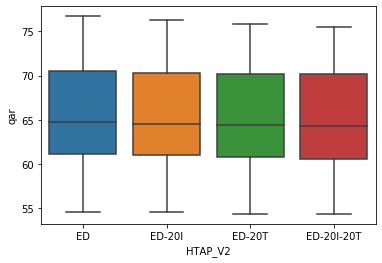

In [43]:
sns.boxplot(data=boxed_df.melt(value_name='qar', var_name='HTAP_V2'), x='HTAP_V2',y='qar')

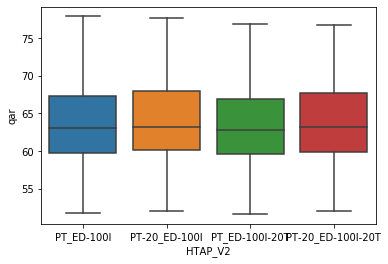

In [44]:
sns.boxplot(data=boxpt_df.melt(value_name='qar', var_name='HTAP_V2'), x='HTAP_V2',y='qar')

In [ ]:
ed_df = pd.Series(aconc[0].variables[param][:,:,:].stack(d=['LAT','LON','TSTEP']))